In [172]:
%matplotlib inline

In [173]:
from git import Repo
from functools import partial
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import saapy.util
from saapy.vcs import check_file_move

In [186]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams['figure.figsize'] = (16, 6)

## Git Utils

In [2]:
def get_commits(repo, revs, paths='', **kwargs):
    commits = []
    visited_commit_hexsha = set()
    for rev in revs:
        for commit in repo.iter_commits(rev=rev, paths=paths, **kwargs):
            commit_hexsha = commit.hexsha
            if commit_hexsha in visited_commit_hexsha:
                continue
            else:
                visited_commit_hexsha.add(commit_hexsha)
            commits.append(commit)
    return commits

In [93]:
def extract_actors(commits, actor_type, attrs):
    actor_attrs = ['{}.{}'.format(actor_type, attr) for attr in attrs]
    actors = saapy.util.dicts_to_dataframe(list(
        saapy.util.objs_to_dicts(commits, actor_attrs)))
    actors = actors.groupby(by=actor_attrs).size()
    actors = actors.reset_index().sort_values(actor_attrs)
    actors.rename(columns=dict(list(zip(actor_attrs, attrs)) + [(0, '{}_commits'.format(actor_type))]), inplace=True)
    return actors

def commits_to_actor_frame(commits):
    attrs = ('name', 'email')
    authors = extract_actors(commits, 'author', attrs)
    committers = extract_actors(commits, 'committer', attrs)
    actors = pd.merge(authors, committers, on=attrs, how='outer')
    actors = actors.drop_duplicates().reset_index(drop=True).fillna(0)
    for attr in attrs:
        actors[attr] = actors[attr].astype('category')
    for col_name in ('author_commits', 'committer_commits'):
        actors[col_name] = actors[col_name].astype('int')
    return actors

def connect_actors(actor_frame, connectivity_sets, connectivity_column):
    connectivity = {}
    for actor_id, connectivity_set in connectivity_sets.items():
        for actor in connectivity_set:
            connectivity[actor] = actor_id
    actor_frame[connectivity_column] = pd.Series(connectivity).astype('category')
    return actor_frame

def combine_actors(actor_frame, connectivity_column):
    aggregator = {'name':'first', 'email': 'first', 
                  'author_commits': 'sum', 
                  'committer_commits': 'sum'}
    return actor_frame.groupby(connectivity_column).agg(aggregator)

In [4]:
def refs_to_ref_frame(git_refs):
    attrs = {'__class__.__name__': 'ref_type', 'name': 'name', 
             'path': 'path', 'commit.hexsha': 'commit'}
    ref_frame = saapy.util.dicts_to_dataframe(list(
        saapy.util.objs_to_dicts(git_refs, attrs.keys())))
    ref_frame.rename(columns=attrs, inplace=True)
    return ref_frame

In [42]:
def commits_to_frame(commits):
    commit_attrs = (
        'hexsha', 'name_rev', 'size', 
        'author.name', 'author.email',
        'authored_datetime', 'author_tz_offset',
        'committer.name', 'committer.email',
        'committed_datetime', 'committer_tz_offset',
        'encoding', 'message',
        'stats.total.files', 'stats.total.lines',
        'stats.total.insertions', 'stats.total.deletions', 
        'stats.files')
    column_names = {attr: attr.replace('.', '_') for attr in commit_attrs}
    commit_frame = saapy.util.dicts_to_dataframe(list(
        saapy.util.objs_to_dicts(commits, commit_attrs)))
    commit_frame.rename(columns=column_names, inplace=True)
    commit_frame['name_rev'] = commit_frame['name_rev'].str.split(' ', 1).apply(lambda x: x[-1])
    categorical_cols = (
        'name_rev', 'author_name', 'author_email', 
        'committer_name', 'committer_email', 'encoding')
    for c in categorical_cols:
        commit_frame[c] = commit_frame[c].astype('category')
    for c in ('authored_datetime', 'committed_datetime'):
        commit_frame[c] = commit_frame[c].astype('datetime64[ns]')
    commit_frame['message'] = commit_frame['message'].str.replace('\n', '\\n')
    commit_frame = commit_frame.sort_values('committed_datetime', ascending=False).reset_index(drop=True)
    return commit_frame

In [57]:
def commit_parents_to_frame(commits):
    commit_parents = []
    for c in commits:
        hexsha = c.hexsha
        parent_hexshas = [p.hexsha for p in c.parents]
        if not len(parent_hexshas):
            commit_parents.append(dict(hexsha=hexsha, parent_hexsha=None))
        else:
            commit_parents.extend(
                (dict(hexsha=hexsha, parent_hexsha=p) 
                 for p in parent_hexshas))
    return pd.DataFrame(commit_parents, columns=['hexsha', 'parent_hexsha'])

In [125]:
def insert_actor_ids(commit_frame, actor_frame, drop_name_email=True):
    actor_columns = ['author_name', 'author_email', 
                     'committer_name', 'committer_email']
    cf = commit_frame[actor_columns]
    af = actor_frame[['name', 'email', 'actor_id']]
    author = pd.merge(
        cf, af, left_on=actor_columns[:2], 
        right_on=('name', 'email'), 
        how='left')['actor_id']
    committer = pd.merge(
        cf, af, left_on=actor_columns[2:], 
        right_on=('name', 'email'), 
        how='left')['actor_id']
    commit_frame.insert(3, 'author', author)
    commit_frame.insert(4, 'committer', committer)
    if drop_name_email:
        commit_frame.drop(actor_columns, axis=1, inplace=True)
    return commit_frame

In [156]:
def commit_trees_to_frame(commits):
    frame = pd.concat((commit_tree_to_frame(c) 
                       for c in commits))
    cat_columns = ('hexsha', 'tree', 'child', 'child_type')
    for col in cat_columns:
        frame[col] = frame[col].astype('category')
    frame.reset_index(inplace=True, drop=True)
    return frame

def commit_tree_to_frame(commit):
    tree_dicts = []
    _add_subtree(tree_dicts, commit.tree, '.')
    tree_frame = pd.DataFrame(tree_dicts)
    tree_frame['hexsha'] = commit.hexsha
    tree_frame['child_type'] = tree_frame['child_type'].astype('category')
    return tree_frame

def _add_subtree(tree_dicts, tree, tree_path):
    tree_dicts.extend((
        dict(tree=tree_path, child=subtree.path, child_type='tree') 
        for subtree in tree.trees))
    tree_dicts.extend((
        dict(tree=tree_path, child=blob.path, child_type='blob') 
        for blob in tree.blobs))
    for subtree in tree.trees:
        _add_subtree(tree_dicts, subtree, subtree.path)

## Git History Extraction

In [6]:
repo = Repo('~/Projects/3party/povray')

In [7]:
commits = get_commits(repo, (ref.commit.hexsha for ref in repo.refs))

### Refs Extraction

In [8]:
ref_frame = refs_to_ref_frame(repo.refs)
ref_frame.to_feather('povray-data/ref_frame.feather')
ref_frame.sample(n=10)

,ref_type,name,path,commit
35,TagReference,v3.7.1-alpha.8509766+av119,refs/tags/v3.7.1-alpha.8509766+av119,c5f8d78e2116a02daed2151e02234095fe4d5642
5,RemoteReference,origin/feature/advanced_diffuse,refs/remotes/origin/feature/advanced_diffuse,4f60e9582305ae3ee6f433610c647f0ed46c12db
10,RemoteReference,origin/hotfix/OTOc_issue,refs/remotes/origin/hotfix/OTOc_issue,3ca747638817160e5a84e882556e0a193481fe18
39,TagReference,v3.7.1-alpha.8555867+av123,refs/tags/v3.7.1-alpha.8555867+av123,12f9827ddf0f3626667736a969d617a54d9990f2
2,RemoteReference,origin/HEAD,refs/remotes/origin/HEAD,1e3b586b2fce101fd150748fcb4a426ac32e9fb9
44,TagReference,v3.7.1-alpha.8696519,refs/tags/v3.7.1-alpha.8696519,2dc0dadccd33918a3fdb42920738b59404fc4a50
11,RemoteReference,origin/hotfix/configure_ac,refs/remotes/origin/hotfix/configure_ac,0b403907a366b56fa07ce286e03ef5258d5bba81
57,TagReference,v3.7.1-alpha.8901709,refs/tags/v3.7.1-alpha.8901709,588df5bb235d7669c5664ca713865f0de9082f0e
73,TagReference,v3.7.1-x.knockout.8881807,refs/tags/v3.7.1-x.knockout.8881807,e205d7762bea11f25a151549908a3ee8d8ef6ad0
30,TagReference,v3.7.1-alpha.8497793+av110,refs/tags/v3.7.1-alpha.8497793+av110,f6888be84b860f1c35e61e2fd8e54d04fbcb65ba


### Actor Extraction

In [97]:
actor_frame = commits_to_actor_frame(commits)
actor_frame.to_feather('povray-data/actor_frame.feather')
actor_frame

,name,email,author_commits,committer_commits
0,Anshu Arya,github@anshuarya.com,2,0
1,BentSm,bentsm@gmail.com,5,0
2,Campbell Barton,ideasman42@gmail.com,1,1
3,Chris Cason,chris20@users.noreply.github.com,6,6
4,Christoph Lipka,c-lipka@users.noreply.github.com,528,560
5,Christoph Lipka,christoph@lipka-koeln.de,15,15
6,Denis Bodor,lefinnois@gmail.com,1,0
7,Justin Lecher,jlec@gentoo.org,2,2
8,Jérôme Grimbert,jgrimbert@free.fr,2,2
9,Nicolás Alvarez,nicolas.alvarez@gmail.com,1,1


In [98]:
same_actors = {
    'ccason': [3, 14, 15], 'clipka': [4, 5, 13], 
    'wfpokorny': [11, 17], 'anshuarya': [0], 
    'bentsm': [1], 'cbarton': [2], 'dbodor': [6], 
    'jlecher': [7], 'jgrimbert': [8], 'nalvarez': [9], 
    'selvik': [10], 'wverhelst': [12], 'gryken': [16], 
    'github': [18]}
actor_frame = connect_actors(actor_frame, same_actors, 'actor_id')
actor_frame

,name,email,author_commits,committer_commits,actor_id
0,Anshu Arya,github@anshuarya.com,2,0,anshuarya
1,BentSm,bentsm@gmail.com,5,0,bentsm
2,Campbell Barton,ideasman42@gmail.com,1,1,cbarton
3,Chris Cason,chris20@users.noreply.github.com,6,6,ccason
4,Christoph Lipka,c-lipka@users.noreply.github.com,528,560,clipka
5,Christoph Lipka,christoph@lipka-koeln.de,15,15,clipka
6,Denis Bodor,lefinnois@gmail.com,1,0,dbodor
7,Justin Lecher,jlec@gentoo.org,2,2,jlecher
8,Jérôme Grimbert,jgrimbert@free.fr,2,2,jgrimbert
9,Nicolás Alvarez,nicolas.alvarez@gmail.com,1,1,nalvarez


In [99]:
combine_actors(actor_frame, 'actor_id')

,name,email,author_commits,committer_commits
actor_id,,,,
anshuarya,Anshu Arya,github@anshuarya.com,2,0
bentsm,BentSm,bentsm@gmail.com,5,0
cbarton,Campbell Barton,ideasman42@gmail.com,1,1
ccason,Chris Cason,chris20@users.noreply.github.com,20,20
clipka,Christoph Lipka,c-lipka@users.noreply.github.com,553,585
dbodor,Denis Bodor,lefinnois@gmail.com,1,0
github,GitHub,noreply@github.com,0,9
gryken,gryken2014,gryken2014@users.noreply.github.com,3,0
jgrimbert,Jérôme Grimbert,jgrimbert@free.fr,2,2


### Commit Extraction

In [45]:
commit_frame = commits_to_frame(commits)
stats_files_frame = commit_frame[['hexsha', 'stats_files']]
commit_frame.drop('stats_files', axis=1, inplace=True)
commit_frame.to_feather('povray-data/commit_frame.feather')
commit_frame.head()

,hexsha,name_rev,size,author_name,author_email,authored_datetime,author_tz_offset,committer_name,committer_email,committed_datetime,committer_tz_offset,encoding,message,stats_total_files,stats_total_lines,stats_total_insertions,stats_total_deletions
0,ea3d549a0c27c0dfb5c51e9fcd980866cfaf654b,remotes/origin/release/v3.7.1,370,Anshu Arya,github@anshuarya.com,2017-04-13 21:21:44,25200,Christoph Lipka,c-lipka@users.noreply.github.com,2017-04-13 21:21:44,-7200,UTF-8,Update AVXFMA4 noise implementation (#268)\n\n...,1,598,156,442
1,8a8c73e2edc8d55ff3e9e6762eefccf19ae07914,remotes/origin/release/v3.7.1~1,710,Anshu Arya,github@anshuarya.com,2017-04-13 21:19:21,25200,Christoph Lipka,c-lipka@users.noreply.github.com,2017-04-13 21:19:21,-7200,UTF-8,Add alternative AVX-optimized noise implementa...,9,357,352,5
2,3adbf759bf0b6be311dfe4d9b75c781bb8208999,remotes/origin/release/v3.7.1~2,333,wfpokorny,wfpokorny@yahoo.com,2017-04-12 20:41:44,14400,Christoph Lipka,c-lipka@users.noreply.github.com,2017-04-12 20:41:44,-7200,UTF-8,Improve AA performance. (#270)\n\nEspecially h...,1,5,2,3
3,2be22dd2068c7e1bacf134b788775ca4579ef664,remotes/origin/release/v3.7.1~3,291,wfpokorny,wfpokorny@yahoo.com,2017-04-06 11:18:13,14400,Christoph Lipka,c-lipka@users.noreply.github.com,2017-04-06 11:18:13,-7200,UTF-8,Relax Parse_Lathe point checking for versions ...,1,18,15,3
4,59ab7f260bc1250591cc6b5e8f544ac53f134039,remotes/origin/release/v3.7.1~4,317,Christoph Lipka,c-lipka@users.noreply.github.com,2017-04-04 14:16:39,-7200,Christoph Lipka,c-lipka@users.noreply.github.com,2017-04-04 14:16:39,-7200,UTF-8,Fix optional parameters of command-line-style ...,2,24,18,6


In [13]:
commit_frame.describe()

,size,stats_total_files,stats_total_lines,stats_total_insertions,stats_total_deletions
count,627.000000,627.000000,6.270000e+02,6.270000e+02,6.270000e+02
mean,370.805423,132.472089,2.375757e+04,1.537852e+04,8.379051e+03
std,173.704885,922.123129,1.708063e+05,1.274965e+05,1.015400e+05
min,181.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,293.000000,1.000000,1.200000e+01,6.000000e+00,3.000000e+00
50%,323.000000,3.000000,5.100000e+01,3.300000e+01,1.000000e+01
75%,359.000000,12.000000,3.585000e+02,2.130000e+02,1.050000e+02
max,1810.000000,9697.000000,1.808794e+06,1.772357e+06,1.772369e+06


In [47]:
stats_files_frame.loc[0, 'stats_files']

{'platform/x86/avxfma4noise.cpp': {'deletions': 442,
  'insertions': 156,
  'lines': 598}}

In [87]:
file_changes = []
for row in stats_files_frame.itertuples():
    for file_path, file_change in row.stats_files.items():
        file_path1, file_path2 = check_file_move(file_path)
        move = file_path1 != file_path2
        d = dict(hexsha=row.hexsha, 
                 file_path1=file_path1, 
                 file_path2=file_path2, 
                 move=move)
        d.update(file_change)
        file_changes.append(d)
file_frame = pd.DataFrame(file_changes, columns=(
    'hexsha', 'file_path1', 'file_path2', 'move', 'lines', 'insertions', 'deletions'))

In [88]:
file_frame.to_feather('povray-data/file_frame.feather')

In [89]:
file_frame.sample(n=10)

,hexsha,file_path1,file_path2,move,lines,insertions,deletions
36185,7086fa93080aceaf62a342617b6b783a392571b9,libraries/boost/boost/log/detail/copy_cv.hpp,libraries/boost/boost/log/detail/copy_cv.hpp,False,64,0,64
33477,7086fa93080aceaf62a342617b6b783a392571b9,libraries/boost/boost/detail/identifier.hpp,libraries/boost/boost/detail/identifier.hpp,False,2,2,0
19810,0b10a891647bf2b0f83fe7e195423878f1659a48,libraries/boost/boost/unordered/detail/node.hpp,libraries/boost/boost/unordered/detail/node.hpp,False,226,0,226
67427,8bbea3af4087432f78197542c26eacaeb4f40ba2,libraries/boost/boost/predef/architecture/x86/...,libraries/boost/boost/predef/architecture/x86/...,False,87,87,0
1610,4379bd23e033b1beade56f72738f75599e830f79,libraries/boost/boost/container/pmr/pool_optio...,libraries/boost/boost/container/pmr/pool_optio...,False,52,52,0
11338,4f3f49eb9e3c31294d27a4fad0acd178c04f13b1,libraries/openexr/IlmImf/ImfLut.h,libraries/openexr/IlmImf/ImfLut.h,False,19,11,8
78026,86f4639d37fc735d330cdfe9ee6bd9c71e159ad5,distribution/scenes/templates/Textures_Materia...,distribution/scenes/templates/Textures_Materia...,False,0,0,0
57897,bd4b762feb6721b04a5ae7dc058dfc00254f58d6,libraries/boost/boost/ptr_container/ptr_set_ad...,libraries/boost/boost/ptr_container/ptr_set_ad...,False,692,692,0
5783,766e1bdc6d3474f80d92bad5578a5c2eba417b19,libraries/boost/boost/archive/impl/xml_woarchi...,libraries/boost/boost/archive/impl/xml_woarchi...,False,44,31,13
10616,4f3f49eb9e3c31294d27a4fad0acd178c04f13b1,libraries/boost/boost/test/utils/basic_cstring...,libraries/boost/boost/test/utils/basic_cstring...,False,150,150,0


In [90]:
move_frame = file_frame[file_frame.move]

In [92]:
move_frame.sample(n=10)

,hexsha,file_path1,file_path2,move,lines,insertions,deletions
11856,f9099be80e92b63abfe1d3cf50b52097278db9e5,distribution/platform-specific/windows/Insert ...,distribution/platform-specific/windows/Insert ...,True,0,0,0
397,1e3b586b2fce101fd150748fcb4a426ac32e9fb9,windows/vs10/povfrontend.vcxproj,windows/vs2015/povfrontend.vcxproj,True,199,121,78
591,5e34fd04d4c3fcb3e2f47d2bb521cc80a1068699,windows/vs10/boost_date_time.vcxproj.filters,windows/vs2015/boost_date_time.vcxproj.filters,True,0,0,0
640,5e34fd04d4c3fcb3e2f47d2bb521cc80a1068699,windows/vs10/vfewin.vcxproj,windows/vs2015/vfewin.vcxproj,True,18,16,2
28929,6ed60adea3195995492635aa27c7c2db018717cc,source/backend/shape/poly.cpp,source/core/shape/polynomial.cpp,True,11,6,5
26235,150f461c62452c3641a5105aafc05ee1424890eb,source/backend/math/mathutil.cpp,source/core/math/mathutil.cpp,True,10,5,5
28652,14e4e23307045894eea7964b7eb5effbae597593,source/backend/render/trace.h,source/core/render/trace.h,True,12,6,6
28912,6ed60adea3195995492635aa27c7c2db018717cc,source/backend/shape/fractal.h,source/core/shape/fractal.h,True,5,3,2
28913,6ed60adea3195995492635aa27c7c2db018717cc,source/backend/shape/hfield.cpp,source/core/shape/heightfield.cpp,True,18,10,8
27585,733ec234086e36bbb71e5d97824b3fa65a1d2209,source/backend/texture/texture.cpp,source/core/material/texture.cpp,True,58,29,29


### Commit Parents Extraction

In [16]:
parent_frame = commit_parents_to_frame(commits)

In [30]:
p1 = parent_frame.groupby('hexsha', as_index=False).agg({'parent_hexsha': 'count'})

In [31]:
mp = p1[p1.parent > 1]

In [35]:
merge_frame = pd.merge(left=commit_frame, right=mp, left_on='hexsha', right_on='hexsha', how='inner')

In [41]:
merge_frame[~merge_frame.message.str.contains('Merge')]

,hexsha,name_rev,size,author_name,author_email,authored_datetime,author_tz_offset,committer_name,committer_email,committed_datetime,committer_tz_offset,stats_total_files,stats_total_lines,stats_total_insertions,stats_total_deletions,encoding,message,commit,parent
32,f9099be80e92b63abfe1d3cf50b52097278db9e5,remotes/origin/coverity_scan~14,334,Christoph Lipka,c-lipka@users.noreply.github.com,2016-09-07 21:22:29,-7200,Christoph Lipka,c-lipka@users.noreply.github.com,2016-09-07 21:22:29,-7200,4587,1199910,914660,285250,UTF-8,Feeding newest code to Coverity Scan.\n,f9099be80e92b63abfe1d3cf50b52097278db9e5,2
46,174aa281ca603935bd3c7e2b6381de5b803e0049,tags/v3.7.1-alpha.8141620^0,319,Christoph Lipka,christoph@lipka-koeln.de,2015-06-24 22:20:55,-7200,Christoph Lipka,christoph@lipka-koeln.de,2015-06-24 22:20:55,-7200,12,1127,803,324,UTF-8,development build v3.7.1-alpha.8141620\n,174aa281ca603935bd3c7e2b6381de5b803e0049,2
48,8550718d652f51fa822a27224f1723d72bb067e6,tags/v3.7.1-alpha.8004333^0,319,Christoph Lipka,christoph@lipka-koeln.de,2015-03-21 13:36:48,-3600,Christoph Lipka,christoph@lipka-koeln.de,2015-03-21 13:37:38,-3600,4,44,36,8,UTF-8,development build v3.7.1-alpha.8004333\n,8550718d652f51fa822a27224f1723d72bb067e6,2
50,733ec234086e36bbb71e5d97824b3fa65a1d2209,tags/v3.7.1-alpha.7981337^0,318,Christoph Lipka,christoph@lipka-koeln.de,2015-03-16 05:00:34,-3600,Christoph Lipka,christoph@lipka-koeln.de,2015-03-16 05:02:12,-3600,1060,246807,182174,64633,UTF-8,development build 3.7.1-alpha.7981337\n,733ec234086e36bbb71e5d97824b3fa65a1d2209,2
59,04cbeb3ef89f45c896ea6dc9b53821d7edfeba06,tags/v3.7.1-alpha.7930357^0,318,Christoph Lipka,christoph@lipka-koeln.de,2015-01-29 11:07:36,-3600,Christoph Lipka,christoph@lipka-koeln.de,2015-01-29 11:13:41,-3600,5,130,82,48,UTF-8,development build 3.7.1-alpha.7930357\n,04cbeb3ef89f45c896ea6dc9b53821d7edfeba06,2
62,2e7b6d647f775a33778ab5a3988ab5ecb50c668e,tags/v3.7.1-alpha.7918791^0,318,Christoph Lipka,christoph@lipka-koeln.de,2015-01-21 22:41:42,-3600,Christoph Lipka,christoph@lipka-koeln.de,2015-01-21 22:41:42,-3600,168,126593,65508,61085,UTF-8,development build 3.7.1-alpha.7918791\n,2e7b6d647f775a33778ab5a3988ab5ecb50c668e,2


### Other

In [128]:
move_frame = file_frame[file_frame.move]

In [131]:
move_graph = nx.from_pandas_dataframe(
    move_frame, 
    source='file_path1', target='file_path2', 
    edge_attr='hexsha', create_using=nx.DiGraph())

In [135]:
move_graph.edges(data=True)[:5]

[('windows/readme.txt',
  'windows/README.md',
  {'hexsha': '9cc71176412281df6f13d260234018e48f7ad958'}),
 ('windows/vs10/StepOver.reg',
  'windows/vs2015/StepOver.reg',
  {'hexsha': '5e34fd04d4c3fcb3e2f47d2bb521cc80a1068699'}),
 ('windows/vs10/autoexp.dat',
  'windows/vs2015/autoexp.dat',
  {'hexsha': '5e34fd04d4c3fcb3e2f47d2bb521cc80a1068699'}),
 ('windows/vs10/boost_date_time.vcxproj',
  'windows/vs2015/boost_date_time.vcxproj',
  {'hexsha': '5e34fd04d4c3fcb3e2f47d2bb521cc80a1068699'}),
 ('windows/vs10/boost_date_time.vcxproj.filters',
  'windows/vs2015/boost_date_time.vcxproj.filters',
  {'hexsha': '5e34fd04d4c3fcb3e2f47d2bb521cc80a1068699'})]

In [136]:
nx.is_directed_acyclic_graph(move_graph)

True

In [137]:
pd.concat?

In [143]:
df = commit_tree_to_frame(repo.head.commit)

In [145]:
df.sample(n=10)

,child,child_type,tree,hexsha
6084,libraries/boost/boost/concept/assert.hpp,blob,libraries/boost/boost/concept,1e3b586b2fce101fd150748fcb4a426ac32e9fb9
9680,libraries/boost/boost/test/unit_test_log.hpp,blob,libraries/boost/boost/test,1e3b586b2fce101fd150748fcb4a426ac32e9fb9
6,tests,tree,.,1e3b586b2fce101fd150748fcb4a426ac32e9fb9
8828,libraries/boost/boost/predef/library/std/_pref...,blob,libraries/boost/boost/predef/library/std,1e3b586b2fce101fd150748fcb4a426ac32e9fb9
9454,libraries/boost/boost/ratio/mpl/less.hpp,blob,libraries/boost/boost/ratio/mpl,1e3b586b2fce101fd150748fcb4a426ac32e9fb9
1459,distribution/platform-specific/windows/Insert ...,blob,distribution/platform-specific/windows/Insert ...,1e3b586b2fce101fd150748fcb4a426ac32e9fb9
4790,distribution/scenes/templates/height_field_and...,blob,distribution/scenes/templates/height_field_and...,1e3b586b2fce101fd150748fcb4a426ac32e9fb9
7960,libraries/boost/boost/mpl/aux_/preprocessed/pl...,blob,libraries/boost/boost/mpl/aux_/preprocessed/plain,1e3b586b2fce101fd150748fcb4a426ac32e9fb9
4231,distribution/scenes/templates/Textures_Materia...,blob,distribution/scenes/templates/Textures_Materia...,1e3b586b2fce101fd150748fcb4a426ac32e9fb9
11834,libraries/tiff/test/strip.c,blob,libraries/tiff/test,1e3b586b2fce101fd150748fcb4a426ac32e9fb9


In [146]:
df1 = commit_trees_to_frame(commits)

In [160]:
df1.to_feather('povray-data/commit_trees.feather')

In [162]:
tree_frame = df1

In [163]:
tree_frame.sample(n=10)

,child,child_type,tree,hexsha
5925398,libraries/boost/boost/mpl/vector/aux_/O1_size.hpp,blob,libraries/boost/boost/mpl/vector/aux_,02213382754c9cffd2cf3951dc7da69eb8de6509
217547,windows/vs10/povbase.vcxproj,blob,windows/vs10,d4cea4d4c05cd36d89e06e28a07ddf20818d185c
323971,distribution/scenes/templates/Textures_Materia...,blob,distribution/scenes/templates/Textures_Materia...,0e8dbe80cead9cf404c2c26c4a1ebf2517259a72
2759741,distribution/platform-specific/windows/Insert ...,blob,distribution/platform-specific/windows/Insert ...,fa3a1dc3a5477b9fa3fcf478bd0f9c1ce50e22c3
807198,distribution/platform-specific/windows/Insert ...,blob,distribution/platform-specific/windows/Insert ...,f24d656061a550b2797c81916fcb1f42b793a716
164011,libraries/boost/boost/units/physical_dimension...,blob,libraries/boost/boost/units/physical_dimensions,dc1a27c0cb8332972b539b23ad79e2d5b9bbde8c
5542946,libraries/boost/boost/archive/iterators/unesca...,blob,libraries/boost/boost/archive/iterators,30aaf025a332f328db928d08e3956da2f603263b
3179987,libraries/boost/boost/mpl/aux_/preprocessed/bc...,blob,libraries/boost/boost/mpl/aux_/preprocessed/bc...,be8158abe96776050e41911afad4932c8fd3ae75
1076323,distribution/scenes/templates/Polynomial_Quart...,blob,distribution/scenes/templates/Polynomial_Quartic,5f89d4146c781bf55eeb559307908cf8bb3849b0
4092681,libraries/boost/boost/range/algorithm_ext/for_...,blob,libraries/boost/boost/range/algorithm_ext,af8fcee2e3afb2bbef40e6762752d2b0d322d6f7


In [164]:
blob_counts = tree_frame[tree_frame.child_type == 'blob'].groupby('child').agg('count')

In [166]:
blob_counts = blob_counts.sort_values('child_type', ascending=False)

In [168]:
blob_counts.describe()

,child_type,tree,hexsha
count,21116.000000,21116.000000,21116.000000
mean,329.864037,329.864037,329.864037
std,292.205910,292.205910,292.205910
min,0.000000,0.000000,0.000000
25%,4.000000,4.000000,4.000000
50%,377.000000,377.000000,377.000000
75%,627.000000,627.000000,627.000000
max,627.000000,627.000000,627.000000


In [171]:
blob_counts[blob_counts.child_type <= 100]

,child_type,tree,hexsha
child,,,
tools/windows/htmlhelp/readme.md,95,95,95
tools/windows/htmlhelp/include/povray37.stp,95,95,95
tools/windows/htmlhelp/include/povray37.js,95,95,95
tools/windows/htmlhelp/include/povray37.hhp,95,95,95
tools/windows/htmlhelp/include/povray37.css,95,95,95
tools/windows/htmlhelp/makedocs.bat,95,95,95
tools/windows/htmlhelp/makedocs.pl,95,95,95
source/source-doc.h,91,91,91
source/base/pov_mem.cpp,91,91,91


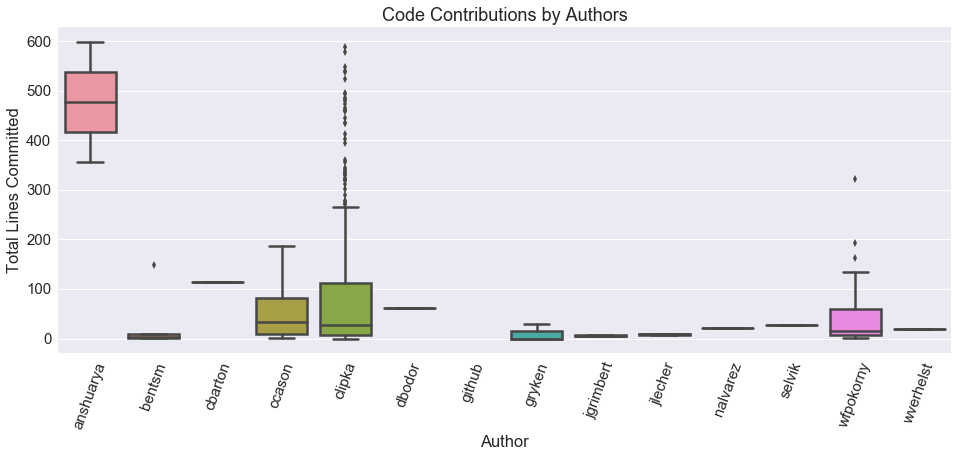

In [188]:
_ = sns.boxplot(x='author', y='stats_total_lines', 
                data=commit_frame[commit_frame.stats_total_lines < 600],  
                orient='v')
_ = plt.title('Code Contributions by Authors')
_ = plt.xlabel('Author')
_ = plt.ylabel('Total Lines Committed')
plt.xticks(rotation=70)
plt.show()

In [189]:
sns.boxplot?